In [1]:
!pip install torch
!pip install pandas
!pip install transformers
!pip install tqdm
!pip install matplotlib


In [2]:
import torch
torch.cuda.is_available()

True

In [4]:
import torch
import pandas as pd
import torch.nn as nn 
from torch.utils.data._utils.collate import default_collate
import numpy as np 
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import re
from tqdm.auto import tqdm
import matplotlib.pyplot as plt 
import os

In [5]:
train_df = pd.read_csv('/kaggle/input/deepakrana-sentimentanalysisdataset/balanced_dataset.csv')
test_df = pd.read_csv('/kaggle/input/deepakrana-sentimentanalysisdataset/preprocessed_test_final.csv')



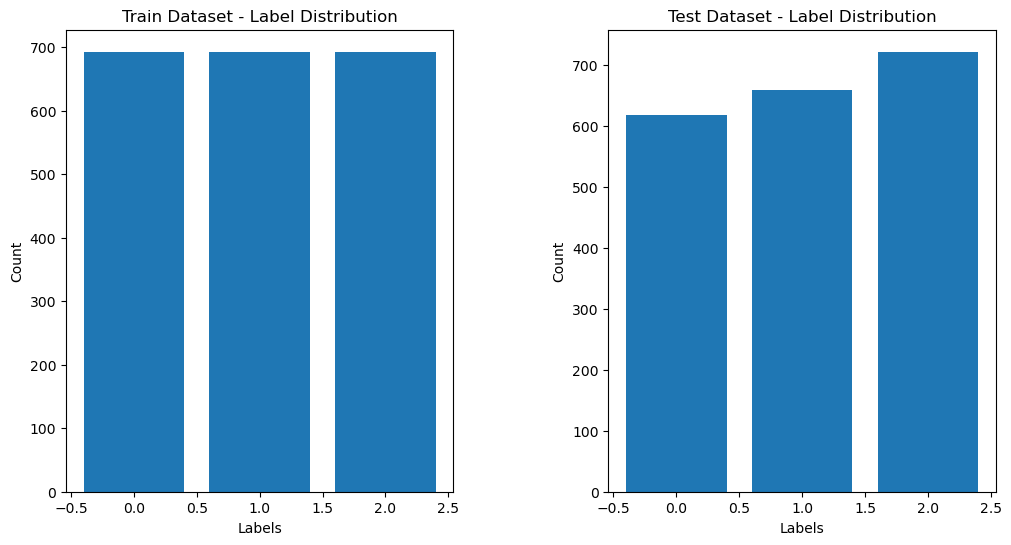

In [6]:
# Bar graph for train dataset
train_labels = train_df['label'].value_counts()

# Bar graph for test dataset
test_labels = test_df['label'].value_counts()

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Train dataset subplot
axs[0].bar(train_labels.index, train_labels.values)
axs[0].set_xlabel('Labels')
axs[0].set_ylabel('Count')
axs[0].set_title('Train Dataset - Label Distribution')

# Test dataset subplot
axs[1].bar(test_labels.index, test_labels.values)
axs[1].set_xlabel('Labels')
axs[1].set_ylabel('Count')
axs[1].set_title('Test Dataset - Label Distribution')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.4)

# Display the plot
plt.show()

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')


In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-uncased', num_labels = 3)

In [32]:
label_encoder = LabelEncoder()
# train_labels = label_encoder.fit_transform(train_df['label'])
# test_labels = label_encoder.transform(test_df['label'])


In [10]:
print(train_labels)

2    693
0    693
1    693
Name: label, dtype: int64


In [13]:
class NepaliSentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len 
        self.label_encoder = LabelEncoder()
        self.labels_encoded = self.label_encoder.fit_transform(labels)
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, index):
        text = str(self.texts[index])
        label = self.labels_encoded[index]
        # Preprocessing steps
        text = re.sub(r'(@.*?)[\s]|&amp;|\s+', lambda m: ' ' if m.group(0) != '&amp;' else '&', text)        
        encoding = self.tokenizer.encode_plus(
            text, 
            add_special_tokens = True,
            max_length = 512,
            padding = 'max_length',
            truncation = True,
            return_attention_mask = True,
            return_tensors = 'pt'
        )
        input_ids = encoding['input_ids']
        attention_mask = encoding['attention_mask']
        return {
            'input_ids': input_ids.squeeze(0),
            'attention_mask': attention_mask,
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [33]:
# tokenizing training data
train_tokens = tokenizer.batch_encode_plus(
    train_df['text'].tolist(),
    padding = True,
    truncation = True,
    max_length = 512,
    return_tensors = 'pt'
)

train_labels = label_encoder.fit_transform(train_df['label'])

In [34]:
# tokenizing test data 
test_tokens = tokenizer.batch_encode_plus(
    test_df['text'].tolist(),
    padding=True,
    truncation=True,
    max_length=512,
    return_tensors='pt'
)

test_labels = label_encoder.fit_transform(test_df['label'])

In [35]:
from torch.utils.data import TensorDataset

# Convert input sequences to tensors
train_input_ids = torch.tensor(train_tokens['input_ids'])
train_attention_masks = torch.tensor(train_tokens['attention_mask'])
train_labels = torch.tensor(train_df['label'].values)

test_input_ids = torch.tensor(test_tokens['input_ids'])
test_attention_masks = torch.tensor(test_tokens['attention_mask'])
test_labels = torch.tensor(test_df['label'].values)

# labels
train_labels = torch.tensor(train_df['label'].values)
test_labels = torch.tensor(test_df['label'].values)


# Create a TensorDataset
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

type(train_dataset)


/tmp/ipykernel_28/720965843.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_input_ids = torch.tensor(train_tokens['input_ids'])
/tmp/ipykernel_28/720965843.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_attention_masks = torch.tensor(train_tokens['attention_mask'])
/tmp/ipykernel_28/720965843.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_input_ids = torch.tensor(test_tokens['input_ids'])
/tmp/ipykernel_28/720965843.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clo

torch.utils.data.dataset.TensorDataset

In [36]:
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [37]:
from torch.utils.data import DataLoader, RandomSampler

batch_size = 16
learning_rate = 2e-5
epochs = 10

train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [38]:
# Setting random seed for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

# Training
model.train()

# Initialize lists to store loss and accuracy values
loss_values = []
accuracy_values = []

for epoch in range(epochs):
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch+1}')

    for batch in progress_bar:
        batch = tuple(t.to(device) for t in batch)
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }

        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        total_loss += loss.item()

        # Calculate accuracy
        predicted_labels = torch.argmax(outputs.logits, dim=1)
        correct_predictions += (predicted_labels == batch[2]).sum().item()
        total_predictions += batch[0].size(0)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Apply gradient clipping if necessary
        optimizer.step()

        progress_bar.set_postfix({'Training Loss': loss.item()})

    average_loss = total_loss / len(train_dataloader)
    accuracy = correct_predictions / total_predictions

    # Store loss and accuracy values
    loss_values.append(average_loss)
    accuracy_values.append(accuracy)

    print(f'Epoch {epoch+1}: Average Loss: {average_loss:.4f} - Accuracy: {accuracy:.4f}')

Epoch 1:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 1: Average Loss: 1.1091 - Accuracy: 0.3348


Epoch 2:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 2: Average Loss: 1.1026 - Accuracy: 0.3627


Epoch 3:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 3: Average Loss: 1.0594 - Accuracy: 0.4334


Epoch 4:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 4: Average Loss: 0.9166 - Accuracy: 0.5685


Epoch 5:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 5: Average Loss: 0.7532 - Accuracy: 0.6643


Epoch 6:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 6: Average Loss: 0.5970 - Accuracy: 0.7566


Epoch 7:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 7: Average Loss: 0.4508 - Accuracy: 0.8297


Epoch 8:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 8: Average Loss: 0.3422 - Accuracy: 0.8773


Epoch 9:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 9: Average Loss: 0.2805 - Accuracy: 0.9004


Epoch 10:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 10: Average Loss: 0.2279 - Accuracy: 0.9245


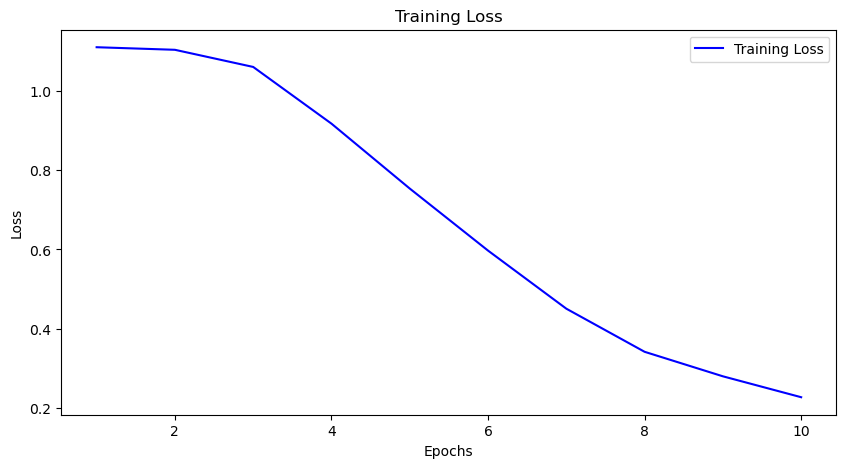

In [39]:
epochs = range(1, epochs+1)

# Loss graph
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_values, 'b', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

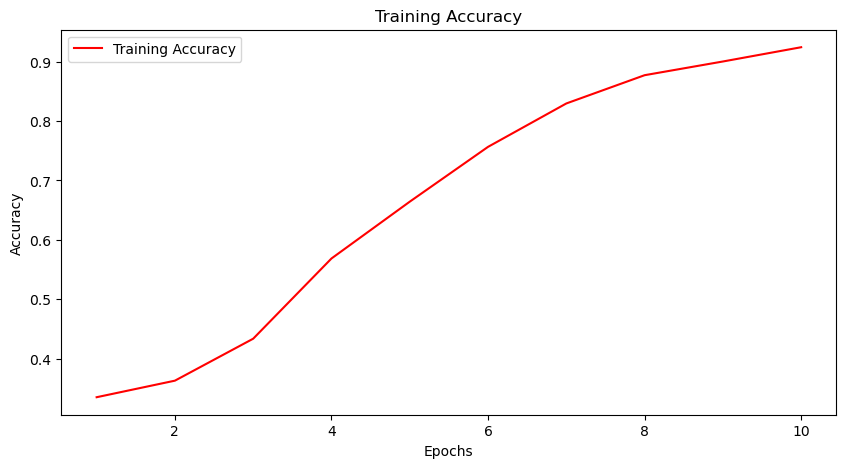

In [40]:
# Accuracy graph
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy_values, 'r', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [41]:
import os
import shutil

# Saving the trained model
output_dir = './trained_model'
os.makedirs(output_dir, exist_ok=True)
model.save_pretrained(output_dir)

print('Training completed!')

# SAVING MODEL
model.save_pretrained("trained_model")

# Create a zip file of the model directory
model_directory = "trained_model"
zip_file_name = "trained_model.zip"

shutil.make_archive(zip_file_name, 'zip', model_directory)

print(f"Zip file '{zip_file_name}' created successfully.")


Training completed!
Zip file 'trained_model.zip' created successfully.


In [9]:
train_dataset = NepaliSentimentDataset(train_df['text'], train_labels, tokenizer, max_len=128)
test_dataset = NepaliSentimentDataset(test_df['text'], test_labels, tokenizer, max_len=128)


In [ ]:
train_dataset[train_labels]

In [11]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=default_collate)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=default_collate)


In [ ]:
def train_model(model, train_dataloader, test_dataloader):
    model.train()
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    epochs = 10
    progress_bar = tqdm(total = len(train_dataloader)*epochs, desc = "Training")
    optimizer = AdamW(model.parameters(), lr = 2e-5, eps=1e-8, no_deprecation_warning=True) 
    train_loss_values = []
    test_accuracy_values = []
    
    for epoch in range(epochs):
        total_loss = 0
        num_batches = 0
        
        for batch in train_dataloader:
            optimizer.zero_grad()
            input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
            # feeding tokens into BERT model 
            output = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = output.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            progress_bar.update(1)
            num_batches+=1
        
        average_loss = total_loss/num_batches
        print(f'Epoch {epoch+1}: Average loss: {average_loss:.4f}')
    return model

trained_model = train_model(model, train_dataloader)


In [ ]:
def evaluate_model(model, test_dataloader):
    model.eval()
    
    device = torch.device('cuda')
    model.to(device)
    
    num_correct = 0
    num_samples = 0
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probabilities = torch.softmax(logits, dim=1)
            predicted_labels = torch.argmax(probabilities, dim=1)
            num_correct += (predicted_labels == labels).sum().item()
            num_samples += labels.size(0)
    accuracy = num_correct/num_samples
    print(f'Evaluate Accuracy: {accuracy:.4f}')
    return accuracy

tested_model = evaluate_model(model, test_dataloader)


OutOfMemoryError: CUDA out of memory. Tried to allocate 312.00 MiB (GPU 0; 14.76 GiB total capacity; 13.73 GiB already allocated; 9.75 MiB free; 13.78 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [55]:
"""Inferencing"""
import os
import torch
from transformers import BertForSequenceClassification, BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
model = BertForSequenceClassification.from_pretrained('/kaggle/working/trained_model', num_labels=3, ignore_mismatched_sizes=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

sentences = ['लेउ यहि खुसि मा चकलेट खाउ']

for text in sentences:
    inputs = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    model.eval()
    with torch.no_grad():
        inputs = {
            'input_ids': input_ids,
            'attention_mask': attention_mask
        }
        outputs = model(**inputs)
    
    logits = outputs.logits
    predicted_labels = torch.argmax(logits, dim=1)
    
    if predicted_labels.item() == 0:
        print(f"Sentence: '{text}' - Negative sentiment")
    elif predicted_labels.item() == 1:
        print(f"Sentence: '{text}' - Positive sentiment")
    else:
        print(f"Sentence: '{text}' - Neutral sentiment")
        


Sentence: 'लेउ यहि खुसि मा चकलेट खाउ' - Positive sentiment
